<h1> OpenSees Examples Manual Examples for OpenSeesPy</h1>
<h2>OpenSees Example 9. Build & Analyze a Section Example</h2>

<p>

You can find the original Examples:<br>
https://opensees.berkeley.edu/wiki/index.php/Examples_Manual<br>
Original Examples by By Silvia Mazzoni & Frank McKenna, 2006, in Tcl<br>
Converted to OpenSeesPy by SilviaMazzoni, 2020<br>
This Example:
https://opensees.berkeley.edu/wiki/index.php/OpenSees_Example_9._Build_%26_Analyze_a_Section_Example    
<p>

    This workbook demonstrates a Moment-Curvature analysis for two types of sections<br>
    1. A uniaxial Section (moment-curvature relationship). <br>
    For the case of the uniaxial section, moment-curvature and axial force-deformation curves are defined independently, and numerically. The uniaxialMaterial command is used to define the moment-curvature relationship.<br>
    2. A fiber section (standard W section).<br>
For the case of the fiber sections (steel and RC), uniaxial materials are defined numerically (stress-strain relationship) and are combined into a fiber section where moment-curvature and axial force-deformation characteristics and their interaction are calculated computationally.
    <p>
        Even though the sections are defined differently, the process of computing the moment-curvature response are the same, as demonstrated in this example.
        <p>

    

<h3>2D vs. 3D</h3>
While this distinction does not affect the section definition itself, it affects the degree-of-freedom associated with moment and curvature in the subsequent analysis. 
There are two differences between the two models:
<ol>
    <li>The space defined with the model command (# Define the model builder, ndm=#dimension, ndf=#dofs)</li>
    <li>  2D: model BasicBuilder -ndm 2 -ndf 3;</li>
    <li>  3D: model BasicBuilder -ndm 3 -ndf 6;</li>
    <li>In the 3D model, torsional stiffness needs to be aggregated to the section</li>
</ol>
This example demonstrates the case of 2D

<p>

     Objectives of Example
    - Build a uniaxialSection: Flexure and axial behavior are uncoupled in this type of section
    - Perform a moment-curvature analysis on Section

<table>
    <tr>
        <td><center><h3>uniaxial Section:</h3></center> <br>
<img src="https://opensees.berkeley.edu/wiki/images/b/b9/ExampleSection_Uniaxial.GIF">
        </td>
        <td><center><h3>Fiber Section:</h3></center> <br>
<img src="https://opensees.berkeley.edu/wiki/images/3/33/ExampleSection_W.GIF">
        </td>
    </tr>
</table>
    
    

In [33]:
############################################################
#  EXAMPLE: 
#       pyEx9a.build.UniaxialSection2D.tcl.py
#          for OpenSeesPy
#  --------------------------------------------------------#
#  by: Silvia Mazzoni, 2020
#       silviamazzoni@yahoo.com
############################################################
# This file was obtained from a conversion of the updated Tcl script
# The Tcl script was obtained by updating the Examples Manual published in the OpenSees Wiki Page
############################################################


import openseespy.opensees as ops
import os
import math
import eSEESminiPy
import numpy as numpy
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------------------------
# build a section
# Silvia Mazzoni and Frank McKenna, 2006
#

# SET UP ----------------------------------------------------------------------------
dataDir  = 'Data' # set up name of data directory -- simple
if not os.path.exists(dataDir):
    os.mkdir(dataDir)
    
# --------------------------------------------------------------------------------------------------
# LibUnits.tcl -- define system of units
# Silvia Mazzoni and Frank McKenna, 2006
#
# define UNITS ----------------------------------------------------------------------------
inch  = 1.  # define basic units -- output units
kip  = 1. # define basic units -- output units
sec  = 1. # define basic units -- output units
LunitTXT  = 'inch' # define basic-unit text for output
FunitTXT  = 'kip' # define basic-unit text for output
TunitTXT  = 'sec' # define basic-unit text for output
ft  = 12.*inch # define engineering units
ksi  = kip/math.pow(inch,2)
psi  = ksi/1000.
lbf  = psi*inch*inch # pounds force
pcf  = lbf/math.pow(ft,3) # pounds per cubic foot
psf  = lbf/math.pow(ft,3) # pounds per square foot
inch2  = inch*inch # inch^2
inch4  = inch*inch*inch*inch # inch^4
cm  = inch/2.54 # centimeter, needed for displacement input in MultipleSupport excitation
PI  = 2*math.asin(1.0) # define constants
g  = 32.2*ft/math.pow(sec,2) # gravitational acceleration
Ubig  = 1.e10 # a really large number
Usmall  = 1/Ubig # a really small number


In [34]:
# Define a function to run moment-curvature analysis

############################################################
#  EXAMPLE: 
#       pyLibMomentCurvature2D.tcl.py
#          for OpenSeesPy
#  --------------------------------------------------------#
#  by: Silvia Mazzoni, 2020
#       silviamazzoni@yahoo.com
############################################################
# This file was obtained from a conversion of the updated Tcl script
# The Tcl script was obtained by updating the Examples Manual published in the OpenSees Wiki Page
############################################################

def MomentCurvature2D(secTag,axialLoad,maxK,numIncr = 100):
    ##################################################
    # A procedure for performing section analysis (only does
    # moment-curvature, but can be easily modified to do any mode
    # of section reponse.)
    #
    # MHS
    # October 2000
    # modified to 2D and to improve convergence by Silvia Mazzoni, 2006
    # converted to OpenSeesPy by Silvia Mazzoni, 2020
    #
    # Arguments
    # secTag -- tag identifying section to be analyzed
    # axialLoad -- axial load applied to section (negative is compression)
    # maxK -- maximum curvature reached during analysis
    # numIncr -- number of increments used to reach maxK (default 100)
    #
    # Sets up a recorder which writes moment-curvature results to file
    # sectionsecTag.out ... the moment is in column 1, and curvature in column 2
    
    # Define two nodes at (0,0)
    ops.node(1001,0.0,0.0)
    ops.node(1002,0.0,0.0)
    
    # Fix all degrees of freedom except axial and bending
    ops.fix(1001,1,1,1)
    ops.fix(1002,0,1,0)
    
    # Define element
    #    tag ndI ndJ secTag
    ops.element('zeroLengthSection',2001,1001,1002,secTag)
    
    # Create recorder
    ops.recorder('Node','-file','data/Mphi.out','-time','-node',1002,'-dof',3,'disp')     #  output moment (col 1) and curvature (col 2)
    ##notInOpenSeesPy## recorder plot data/Mphi.out MomCurv 1200 10 400 400 -columns 2 1   ##xx##  ##xx## xx ##xx##  ##xx##    ##xx##  a window to plot the nodal displacements versus time
    
    # Define constant axial load
    ops.timeSeries('Constant',3001)     # timeSeries Constant 3001;
    # define Load Pattern
    ops.pattern('Plain',3001,3001) # 
    ops.load(1002,axialLoad,0.0,0.0)
    
    # Define analysis parameters
    ops.wipeAnalysis()     # adding this to clear Analysis module 
    ops.constraints('Plain')
    ops.integrator('LoadControl',0,1,0,0)
    ops.system('SparseGeneral','-piv')     #  Overkill, but may need the pivoting!
    ops.test('EnergyIncr',1.0e-9,10)
    ops.numberer('Plain')
    ops.algorithm('Newton')
    ops.analysis('Static')
    
    # Do one analysis for constant axial load
    ops.analyze(1)
    
    ops.loadConst('-time',0.0)
    
    # Define reference moment
    ops.timeSeries('Linear',3002)     # timeSeries Linear 3002;
    # define Load Pattern
    ops.pattern('Plain',3002,3002) # 
    ops.load(1002,0.0,0.0,1.0)
    
    # Compute curvature increment
    dK  = maxK/numIncr
    
    # Use displacement control at node 1002 for section analysis, dof 3
    ops.integrator('DisplacementControl',1002,3,dK,1,dK,dK)
    
    # Do the section analysis
    ok  = ops.analyze(numIncr)
    
    # ----------------------------------------------if convergence failure-------------------------
    IDctrlNode  = 1002
    IDctrlDOF  = 3
    Dmax  = 'maxK'
    Dincr  = dK
    TolStatic  = 1.e-9
    testTypeStatic  = 'EnergyIncr'
    maxNumIterStatic  = 6
    algorithmTypeStatic  = 'Newton'
    #fmt1 = [%s,Pushover,analysis:,CtrlNode,%.3i,dof,%.1i,Curv=%.4f,/%s] # format for screen/file output of DONE/PROBLEM analysis
    global LunitTXT ##xx##   # load time-unit text
    if ok != 0 :
        # if analysis fails, we try some other stuff, performance is slower inside this loop
        Dstep  = 0.0
        ok  = 0
        while Dstep <= 1.0 and ok == 0 :
            controlDisp  = ops.nodeDisp(IDctrlNode,IDctrlDOF) 
            Dstep  = controlDisp/Dmax
            ok  = ops.analyze(1)   # this will return zero if no convergence problems were encountered
            if ok != 0 :
                Nk  = 4 # reduce step size
                DincrReduced  = Dincr/Nk
                ops.integrator('DisplacementControl',IDctrlNode,IDctrlDOF,DincrReduced)
                for ik in range(1,Nk+1,1):
                    ok  = ops.analyze(1)   # this will return zero if no convergence problems were encountered
                    if ok != 0 :
                        # if analysis fails, we try some other stuff
                        # performance is slower inside this loop global maxNumIterStatic ##xx##  # max no. of iterations performed before "failure to converge" is ret'd
                        print(' "Trying Newton with Initial Tangent ..')
                        ops.test('NormDispIncr',TolStatic,2000,0)
                        ops.algorithm('Newton','-initial')
                        ok  = ops.analyze(1)
                        ops.test(testTypeStatic,TolStatic,maxNumIterStatic,0)
                        ops.algorithm(algorithmTypeStatic)
                    if ok != 0 :
                        print(' "Trying Broyden ..')
                        ops.algorithm('Broyden',8)
                        ok  = ops.analyze(1)
                        ops.algorithm(algorithmTypeStatic)
                    if ok != 0 :
                        print(' "Trying NewtonWithLineSearch ..')
                        ops.algorithm('NewtonLineSearch',0.8)
                        ok  = ops.analyze(1)
                        ops.algorithm(algorithmTypeStatic)
                    if ok != 0 :
                        print('PROBLEM')
                        return 
                ops.integrator('DisplacementControl',IDctrlNode,IDctrlDOF,Dincr)     #  bring back to original increment
        # -----------------------------------------------------------------------------------------------------
        
        if ok != 0  :
            print('PROBLEM at NodeDisp=' + str(ops.nodeDisp(IDctrlNode,IDctrlDOF)) +  LunitTXT)
        else :
            print('DONE! at NodeDisp=' + str(ops.nodeDisp(IDctrlNode,IDctrlDOF)) +  LunitTXT)
        
        
    


In [35]:
# UNIAXIAL SECTION IN 2d
ops.wipe()     #  clear memory of all past model definitions
ops.model('BasicBuilder','-ndm',2,'-ndf',3)     #  Define the model builder, ndm= dimension, ndf= dofs
# Define your SECTION
# MATERIAL parameters -------------------------------------------------------------------
SecTagFlex  = 2 # assign a tag number to the column flexural behavior
SecTagAxial  = 3 # assign a tag number to the column axial behavior
SecTag  = 1 # assign a tag number to the column section tag

# COLUMN section
# calculated stiffness parameters
EASec  = Ubig # assign large value to axial stiffness
MySec  = 130000*kip*inch # yield moment
PhiYSec  = 0.65e-4/inch # yield curvature
EICrack  = MySec/PhiYSec # cracked section inertia
b  = 0.01  # strain-hardening ratio (ratio between post-yield tangent and initial elastic tangent)
ops.uniaxialMaterial('Steel01',SecTagFlex,MySec,EICrack,b)     #  bilinear behavior for flexural moment-curvature
ops.uniaxialMaterial('Elastic',SecTagAxial,EASec)     #  this is not used as a material, this is an axial-force-strain response
ops.section('Aggregator',SecTag,SecTagAxial,'P',SecTagFlex,'Mz')     #  combine axial and flexural behavior into one section (no P-M interaction here)


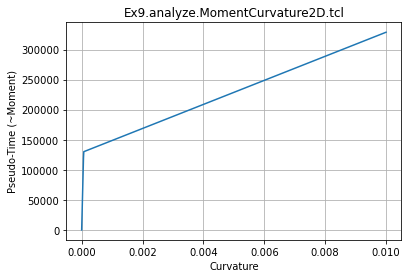

In [36]:
# Perform Moment-Curvature Analysis 
# set AXIAL LOAD --------------------------------------------------------
P  = -1800*kip #+Tension,-Compression

# set maximum Curvature:
Ku  = 0.01/inch
numIncr  = 1000 # Number of analysis increments to maximum curvature (default=100)
# Call the section analysis procedure
MomentCurvature2D(SecTag,P,Ku,numIncr)
ops.wipe()
fname3 = 'Data/Mphi.out'
dataDFree = numpy.loadtxt(fname3)
plt.plot(dataDFree[:,1],dataDFree[:,0])
plt.ylabel('Pseudo-Time (~Moment)')
plt.xlabel('Curvature')
plt.title('Ex9.analyze.MomentCurvature2D.tcl')
plt.grid(True)
plt.show()


In [37]:
# FIBER SECTION IN 2D
# Steel W Section

# SET UP ----------------------------------------------------------------------------
ops.wipe()     #  clear memory of all past model definitions
ops.model('BasicBuilder','-ndm',2,'-ndf',3)     #  Define the model builder, ndm= dimension, ndf= dofs

# MATERIAL parameters -------------------------------------------------------------------
# define MATERIAL properties ----------------------------------------
Fy  = 60.0*ksi
Es  = 29000*ksi # Steel Young's Modulus
nu  = 0.3
Gs  = Es/2./(1+nu) # Torsional stiffness Modulus
Hiso  = 0
Hkin  = 1000
matIDhard  = 1
ops.uniaxialMaterial('Hardening',matIDhard,Es,Fy,Hiso,Hkin)

# Structural-Steel W-section properties -------------------------------------------------------------------
SecTag  = 1
WSec  = 'W27x114'

# from Steel Manuals:
# in × lb/ft Area (in2) d (in) bf (in) tf (in) tw (in) Ixx (in4) Iyy (in4)
# W27x114 33.5 27.29 10.07 0.93 0.57 4090 159
d  = 27.29*inch # nominal depth
tw  = 0.57*inch # web thickness
bf  = 10.07*inch # flange width
tf  = 0.93*inch # flange thickness
nfdw  = 16 # number of fibers along web depth
nftw  = 4 # number of fibers along web thickness
nfbf  = 16 # number of fibers along flange width (you want this many in a bi-directional loading)
nftf  = 4 # number of fibers along flange thickness

dw  = d-2 * tf
y1  = -d/2
y2  = -dw/2
y3  = dw/2
y4  = d/2

z1  = -bf/2
z2  = -tw/2
z3  = tw/2
z4  = bf/2

#
# define Section
ops.section('Fiber',SecTag,'-GJ',1e9) # 
#   nfIJ nfJK yI zI yJ zJ yK zK yL zL
ops.patch('quadr',matIDhard,nfbf,nftf,y1,z4,y1,z1,y2,z1,y2,z4)
ops.patch('quadr',matIDhard,nftw,nfdw,y2,z3,y2,z2,y3,z2,y3,z3)
ops.patch('quadr',matIDhard,nfbf,nftf,y3,z4,y3,z1,y4,z1,y4,z4)


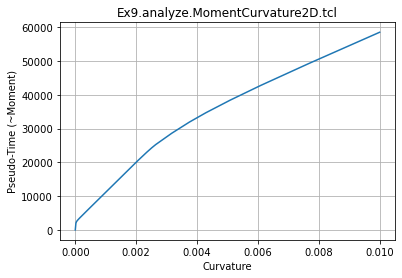

In [38]:
# PERFORM ANALYSIS.
# This block of commands is the same as above
# Perform Moment-Curvature Analysis 
# set AXIAL LOAD --------------------------------------------------------
P  = -1800*kip #+Tension,-Compression

# set maximum Curvature:
Ku  = 0.01/inch
numIncr  = 1000 # Number of analysis increments to maximum curvature (default=100)
# Call the section analysis procedure
MomentCurvature2D(SecTag,P,Ku,numIncr)
ops.wipe()
fname3 = 'Data/Mphi.out'
dataDFree = numpy.loadtxt(fname3)
plt.plot(dataDFree[:,1],dataDFree[:,0])
plt.ylabel('Pseudo-Time (~Moment)')
plt.xlabel('Curvature')
plt.title('Ex9.analyze.MomentCurvature2D.tcl')
plt.grid(True)
plt.show()